<a href="https://colab.research.google.com/github/Nagmashaik123/INFO5505MachineLearning/blob/main/Shaik_Assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**To import the dataset directly from Kaggle below steps are followed.**

In [ ]:
!pip install -q kaggle

In [ ]:
# After dowloading the kaggle.json file from kaggle website.
# Uploaded those json file to authenticate the API calls to download the dataset
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nagmask","key":"4fb794f4d573d8bd22e73e0fc6c8d9d0"}'}

In [ ]:
# Executing steps to download the dataset related to images
!rm -d ~/.kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d puneet6060/intel-image-classification

rm: cannot remove '/root/.kaggle': No such file or directory
 98% 340M/346M [00:01<00:00, 208MB/s]
100% 346M/346M [00:02<00:00, 180MB/s]


In [ ]:
# Unzipped the images from the downloaded folders
!unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [ ]:
# Importing all the necessary libraries.
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob as gb 
import cv2
import os, random
import seaborn as sns
from keras.preprocessing import image
import sklearn
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from skimage import transform
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten
from sklearn.utils import shuffle
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Reading the device name
deviceName = tf.test.gpu_device_name()
if deviceName != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(deviceName))

Found GPU at: /device:GPU:0


In [ ]:
# Loading files from the folders training, testing and predicting
trainingPath = '/content/seg_train/seg_train'
testingPath = '/content/seg_test/seg_test'
predictingPath = '/content/seg_pred/seg_pred'

In [ ]:
# To create a CNN model, Preprocessing all the data sets to create a CNN model
# Processing the training, testing, and prediction datasets.
trainData = ImageDataGenerator(rescale = 1./255,    
                                      shear_range = 0.2,
                                      rotation_range=20,
                                      zoom_range = 0.2,
                                      horizontal_flip = True)
trainedData = trainData.flow_from_directory(trainingPath,
                                                      target_size = (64,64),
                                                      class_mode = 'sparse',
                                                      shuffle = True,
                                                      batch_size=32)



Found 14034 images belonging to 6 classes.


In [ ]:
#To normalize the data between 0 and 1, I had divided the data of both training and testing with 255
#Inorder that the pixel values of each image are between 0 and 1.
testData = ImageDataGenerator(rescale = 1./255)
testedData = testData.flow_from_directory(testingPath, 
                                                    target_size = (64,64),
                                                    class_mode = 'sparse',
                                                    shuffle=False,
                                                    batch_size=32)

Found 3000 images belonging to 6 classes.


In [ ]:
# Returning the internal folders
labelEncoding = trainedData.class_indices
labelEncoding

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [ ]:
# Applied Data argumentation method for training image data set.
def getTrainData(source_path):
  image_list = []
  names_list = []
  for name in os.listdir(source_path):
    file_paths = gb.glob(pathname = source_path+ '/'+ name+'/*.jpg')
    for p in file_paths:
      image = plt.imread(p)
      resized_image = cv2.resize(image,(64,64) )
      image_list.append(resized_image)
      names_list.append(labelEncoding[name])
  return image_list, names_list
# Method to return resized images for image augmentation
def x(source_path):
  resizedImages = []
  for name in os.listdir(source_path):
    path_file = source_path+'/'+ name
    image = plt.imread(path_file)
    resized_image = cv2.resize(image,(64,64) )
    resizedImages.append(resized_image)
  return resizedImages


In [ ]:
# Model CNN is created with Convo layers then added with pooling layers which is followed by Dense FC layer to predict classes.
# Input fed to convo layer then output becomes the input to the next layer, the output is then fed to FC layer to predict the labels.
def model_cnn():
  cnn = Sequential()
  cnn.add(Conv2D(32, (3,3), activation='relu', input_shape = (64,64,3)))
  cnn.add(MaxPooling2D(pool_size = (2,2)))
  cnn.add(Conv2D(64, (3,3), activation = 'relu'))
  cnn.add(MaxPooling2D(pool_size = (2,2)))
  cnn.add(Conv2D(64, (3,3), activation = 'relu'))
  cnn.add(MaxPooling2D(pool_size = (2,2)))
  cnn.add(Flatten())
  cnn.add(Dense(32, activation = 'relu'))
  cnn.add(Dense(16, activation = 'relu'))
  cnn.add(Dense(6, activation = 'softmax'))
  return cnn
# Method to draw plots for visualisation
def drawPlot(value1, value2):
  plt.figure(figsize=(6,6))
  plt.plot(history.history[value1],'orange', label = 'train_accuracy')
  plt.plot(history.history[value2], 'g', label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title('Training and validation accuracy')
  plt.show()

In [ ]:
# Loading images from the file path and then transformed to the size to using resize method
def load_image(path):
  file_path = random.choice(gb.glob(pathname = path+'/*.jpg'))
  img = image.load_img(file_path, target_size=(150, 150))
  np_image = np.array(img).astype('float32')/255
  np_image = transform.resize(np_image, (64, 64, 3))
  np_image_exp = np.expand_dims(np_image, axis=0)
  return img,np_image_exp

def load_image(path):
  file_path = random.choice(gb.glob(pathname = path+'/*.jpg'))
  img = image.load_img(file_path, target_size=(150, 150))
  np_image = np.array(img).astype('float32')/255
  np_image_exp = np.expand_dims(np_image, axis=0)
  return img,np_image_exp

In [ ]:
# Fetching the training data
X_train, y_train = getTrainData(trainingPath)
print('Printing the training data set:', len(X_train), len(y_train))

# Fetching the predicting data
X_pred =  x(predictingPath)
print('Printing the Predicting data set:', len(X_pred))

# Shuffling data with random sate as 45 by reading data using np arrays.
X_train, y_train = sklearn.utils.shuffle(np.array(X_train), np.array(y_train), random_state = 45)
X_pred = np.array(X_pred)

Printing the training data set: 14034 14034
Printing the Predicting data set: 7301


In [ ]:
kfold = KFold(n_splits = 10, shuffle = True)
foldAccuracy = []
foldLoss = []
fold = 1
#To perform cross validation I had divided the training set into K-folds. 
for train, test in kfold.split(np.zeros(len(y_train)),y_train):
  train_generated = train_generator.flow(X_train[train], y_train[train], batch_size=32)
  val_generated = test_generator.flow(X_train[test], y_train[test], batch_size=32)
  cnn = model_cnn()
  cnn.compile(optimizer = 'adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics = ['accuracy'])
  history = cnn.fit(train_generated,  
                    epochs = 5,
                    validation_data=(val_generated) )

#Over each of 10 k-folds, the model is trained on 5 epochs
  scores = cnn.evaluate(val_generated, verbose=1)
  print(f"Score of fold: {fold}: {cnn.metrics_names[0]} is {scores[0]}, {cnn.metrics_names[1]} is {scores[1]}")
  
  foldLoss.append(scores[0])
  foldAccuracy.append(scores[1])
  fold += 1
# Determining the generalized scores for the CNN model built, The model is only 75% accurate.
print('Accuracy: ', np.mean(foldAccuracy))
print('Loss: ', np.mean(foldLoss))


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


395/395 [==============================] - 30s 54ms/step - loss: 1.2644 - accuracy: 0.4791 - val_loss: 1.1652 - val_accuracy: 0.5812
Epoch 2/5
395/395 [==============================] - 21s 52ms/step - loss: 0.9482 - accuracy: 0.6335 - val_loss: 0.8717 - val_accuracy: 0.6866
Epoch 3/5
395/395 [==============================] - 20s 50ms/step - loss: 0.8274 - accuracy: 0.6913 - val_loss: 0.7211 - val_accuracy: 0.7322
Epoch 4/5
395/395 [==============================] - 19s 48ms/step - loss: 0.7535 - accuracy: 0.7226 - val_loss: 0.7110 - val_accuracy: 0.7486
Epoch 5/5
44/44 [==============================] - 0s 7ms/step - loss: 0.6657 - accuracy: 0.7536
Score of fold: 1: loss is 0.6656570434570312, accuracy is 0.75356125831604
Epoch 1/5
395/395 [==============================] - 20s 50ms/step - loss: 1.1912 - accuracy: 0.5224 - val_loss: 0.9210 - val_accuracy: 0.6368
Epoch 2/5
395/395 [==============================] - 19s 48ms/step - loss: 0.9588 - accuracy: 0.6328 - val_loss: 1.1015 - v

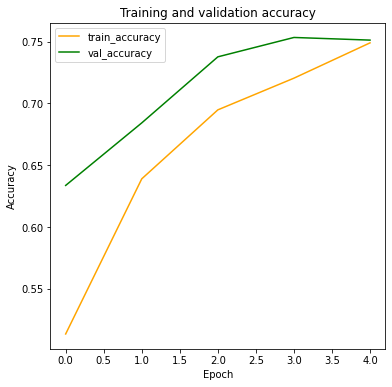

In [ ]:
# Drawing Graphs with out Model Transfer Learning 
# Visualising graph with Training and Validation Accuracy values
drawPlot('accuracy', 'val_accuracy')

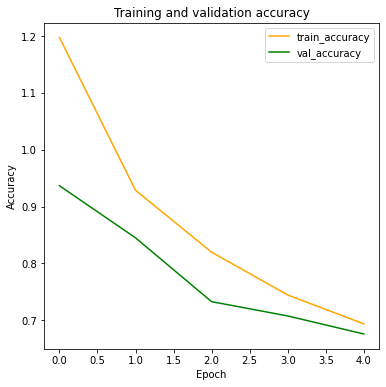

In [ ]:
# Drawing Graphs with out Model Transfer Learning 
# Visualising graph with Training and Validation Loss values
drawPlot('loss', 'val_loss')

In [ ]:
# Calculated the Accuracy and Loss of the CNN Model without Transfer Learning
cnn.fit(train_generated, epochs = 5,  verbose = 1)
model_loss, model_accuracy = cnn.evaluate(test_generated)
print('Loss is: ', model_loss)
print('Accuracy is: ', model_accuracy)

Epoch 1/5
395/395 [==============================] - 20s 50ms/step - loss: 0.6589 - accuracy: 0.7620
Epoch 2/5
395/395 [==============================] - 19s 49ms/step - loss: 0.6160 - accuracy: 0.7775
Epoch 3/5
395/395 [==============================] - 20s 51ms/step - loss: 0.6052 - accuracy: 0.7816
Epoch 4/5
395/395 [==============================] - 20s 50ms/step - loss: 0.5803 - accuracy: 0.7913
Epoch 5/5
 1/94 [..............................] - ETA: 20s - loss: 0.7593 - accuracy: 0.6875

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


94/94 [==============================] - 4s 40ms/step - loss: 0.7035 - accuracy: 0.7550
Loss is:  0.7034611701965332
Accuracy is:  0.7549999952316284


In [ ]:
# Calculating and printing for CNN Model with out Transfer Learning
y_pred = np.argmax(cnn.predict(test_generated), axis=-1) 
y_true = test_generated.classes
print(classification_report(y_true, y_pred, target_names=label_encoding))

              precision    recall  f1-score   support

   buildings       0.55      0.79      0.65       437
      forest       0.89      0.94      0.91       474
     glacier       0.79      0.61      0.69       553
    mountain       0.79      0.68      0.73       525
         sea       0.82      0.69      0.75       510
      street       0.75      0.86      0.80       501

    accuracy                           0.76      3000
   macro avg       0.77      0.76      0.76      3000
weighted avg       0.77      0.76      0.76      3000



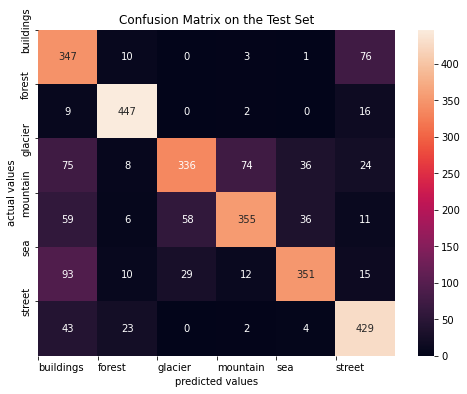

In [ ]:
# Confusion Matrix is plotted for the values of MOdel built on CNN with out Transfer Learning
conf_matrix = confusion_matrix(y_true, y_pred)
label_names = [k for k in label_encoding.keys()]
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot = True, fmt=".0f")
tick_marks = np.arange(len(label_names))
plt.xticks(tick_marks, label_names, horizontalalignment='left')
#Plotting graph
plt.yticks(tick_marks, label_names)
plt.xlabel('predicted values')
plt.ylabel('actual values')
plt.title('Confusion Matrix on the Test Set')
plt.show()

In [ ]:
# Running the prediction Model  calling the Image Data Generator by passing the rescaling image size.
pred_generator = ImageDataGenerator(rescale = 1./255)
pred_generated = pred_generator.flow(X_pred, batch_size=32, shuffle = False)
y_pred = cnn.predict(pred_generated, batch_size=32)

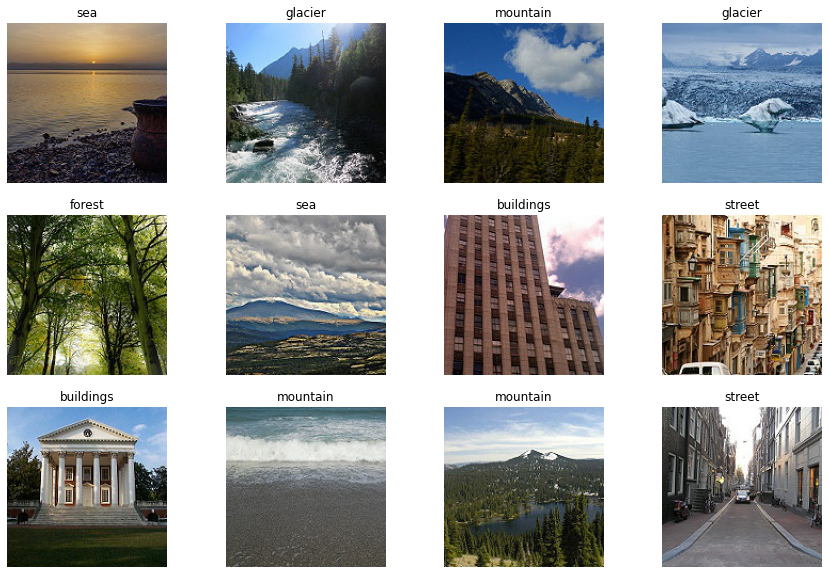

In [ ]:
# Running the prediction Model  calling the Image Data Generator by passing the rescaling image size.
classes_decoded = dict([(v, k) for k, v in label_encoding.items()])
plt.figure(figsize=(15,10))

for i in range (12):
  ax = plt.subplot(3,4,i+1)
  img = load_image(pred_path)
  label=np.argmax(cnn.predict(img[1]), axis=-1)
  plt.title(classes_decoded[int(label)])
  plt.imshow(img[0])
  plt.axis("off")
   

In [ ]:
# CNN Model based on Transfer Learning
# Data is divided into the training and validation subsets
train_generator = ImageDataGenerator(rescale = 1./255,    
                                      shear_range = 0.2,
                                      rotation_range=20,
                                      zoom_range = 0.2,
                                      horizontal_flip = True,
                                      validation_split=0.2) 

# Training data
train_generated = train_generator.flow_from_directory(train_path, 
                                     target_size = (150,150),
                                     class_mode = 'sparse',
                                     batch_size = 32, 
                                     shuffle=True,

# Validation data                                     subset='training') 
val_generated = train_generator.flow_from_directory(train_path, 
                                     target_size = (150,150),
                                     class_mode = 'sparse',
                                     batch_size = 32, 
                                     shuffle=True,
                                     subset='validation')

# Testing data
test_generator = ImageDataGenerator(rescale=1./255)                           
test_generated = test_generator.flow_from_directory(test_path, 
                                     target_size = (150,150),
                                     class_mode = 'sparse',
                                     shuffle = False)


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
# This current CNN Model is built using ResNet50V2
conv = ResNet50V2(input_shape=(150,150, 3), 
                     include_top=False, 
                     weights='imagenet')

no_layers = 200
for layers in conv.layers[:no_layers]:
    layers.trainable = False
# Detailing the summary of the CNN Model
conv.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']    

In [ ]:
# CNN Model built using Transfer Learning
model2 = conv
model2 = model2.output
model2 = tf.keras.layers.GlobalMaxPooling2D()(model2)
model2 = tf.keras.layers.Flatten(name="Flatten")(model2)
model2 = tf.keras.layers.Dense(1024, activation='relu')(model2)
model2 = tf.keras.layers.Dropout(0.2)(model2)
# Calling the Dense layer function to generate the prediction data
prediction_layer = tf.keras.layers.Dense(6, activation='softmax')(model2)
tf_model = tf.keras.Model(inputs=conv.input, outputs=prediction_layer)
tf_model.compile(optimizer='adam', 
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics = 'accuracy')
# Detailing the summary of the model built by running over the datasets

tf_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']         

In [ ]:
# CNN Model with Transfer Learning by calling .fit function to evaluate the Model Accuracy and Loss
history = tf_model.fit(train_generated, 
                     epochs = 5,
                     validation_data=val_generated,
                     batch_size = 32)
loss, model_accuracy = tf_model.evaluate(test_generated)
print('Loss', model_loss)
print('Accuracy', model_accuracy)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


351/351 [==============================] - 108s 292ms/step - loss: 1.0540 - accuracy: 0.8133 - val_loss: 0.4194 - val_accuracy: 0.8488
Epoch 2/5
351/351 [==============================] - 98s 281ms/step - loss: 0.3669 - accuracy: 0.8663 - val_loss: 0.3553 - val_accuracy: 0.8766
Epoch 3/5
351/351 [==============================] - 98s 280ms/step - loss: 0.3454 - accuracy: 0.8742 - val_loss: 0.3613 - val_accuracy: 0.8688
Epoch 4/5
351/351 [==============================] - 98s 280ms/step - loss: 0.3357 - accuracy: 0.8744 - val_loss: 0.3235 - val_accuracy: 0.8741
Epoch 5/5
94/94 [==============================] - 12s 125ms/step - loss: 0.3443 - accuracy: 0.8857
Loss 0.7034611701965332
Accuracy 0.8856666684150696


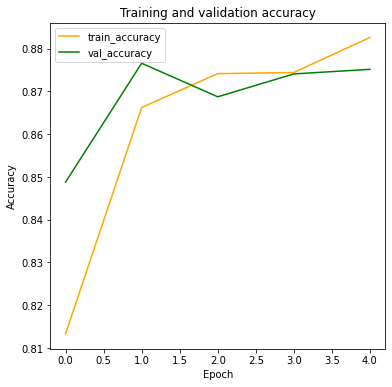

In [ ]:
# Drawing Graphs with Model Transfer Learning 
# Visualising graph with Training and Validation Accuracy values
drawPlot('accuracy', 'val_accuracy')

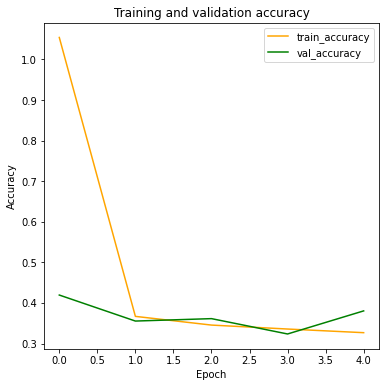

In [ ]:
# Drawing Graphs with Model Transfer Learning 
# Visualising graph with Training and Validation Loss values
drawPlot('loss', 'val_loss')

In [ ]:
# Calculated the precision recall and f1-score with the CNN Model for the different images
y_true = test_generated.classes
label_names = test_generated.class_indices
y_pred = np.argmax(tf_model.predict(test_generated), axis=-1) 
# Printing the classification report by calling the classification_report function by passing the true values vs predicted one
print(classification_report(y_true, y_pred,  target_names=label_names))

              precision    recall  f1-score   support

   buildings       0.85      0.94      0.89       437
      forest       0.98      0.98      0.98       474
     glacier       0.88      0.77      0.82       553
    mountain       0.85      0.80      0.83       525
         sea       0.84      0.96      0.90       510
      street       0.93      0.89      0.91       501

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.88      3000



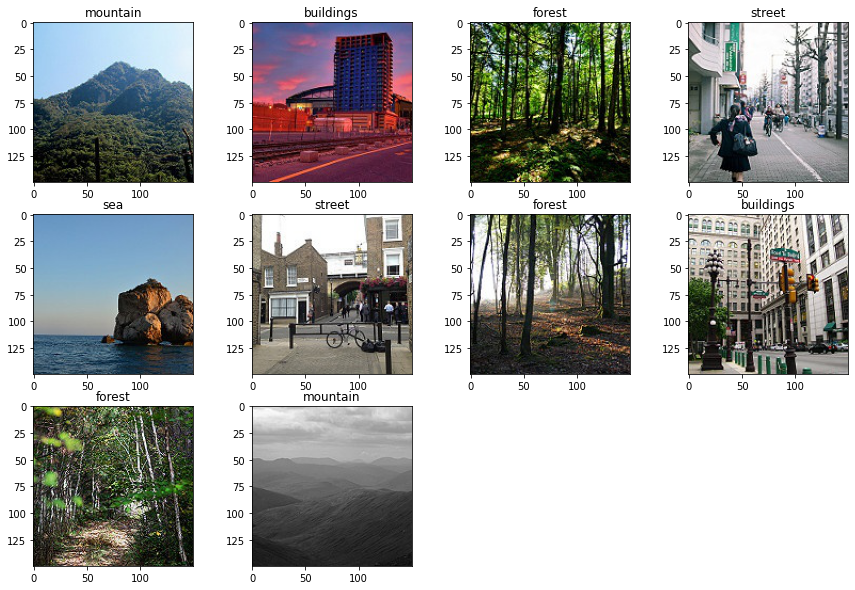

In [ ]:
# Calculated the precision recall and f1-score with the CNN Model for the different images
classes_decoded = dict([(v, k) for k, v in train_generated.class_indices.items()])
plt.figure(figsize=(15,10))
for i in range (10):
  ax = plt.subplot(3,4,i+1)
  img = load_image(pred_path)
  label=np.argmax(tf_model.predict(img[1]), axis=-1)
  plt.title(classes_decoded[int(label)])
  plt.imshow(img[0])